# **SCRAPER to generate the data!**
-- All Members

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from zenrows import ZenRowsClient
client = ZenRowsClient("fa1a58c4dda65f20ad3ea8423dbe1b7ea3b0ced7")

In [ ]:
def get_total_stats(webpage, stat):
    """
    Given a player's college stats page, returns the total stats for the player.
    """
    stat_html = webpage.select(f'td[data-stat="{stat}"]')
    if stat_html:
        return stat_html[-1].get_text()
    else:
        return None

In [ ]:
# Loop over all years in the dataset.
current = False
START_YEAR = 2012
END_YEAR = 2023

STATS_LIST = [
    #Defense and Fumbles
    'tackles_solo',
    'tackles_assists',
    'tackles_total',
    'tackles_loss',
    'sacks',
    'def_int',
    'def_int_yds',
    'def_int_td',
    'pass_defended',
    'fumbles_rec',
    'fumbles_rec_yds',
    'fumbles_rec_td',
    'fumbles_forced',

    # Passing
    'pass_cmp',
    'pass_att',
    'pass_cmp_pct',
    'pass_yds',
    'pass_td',
    'pass_int',
    'pass_rating',

    # Receiving & Rushing
    'rec',
    'rec_yds',
    'rec_yds_per_rec',
    'rec_td',
    'rush_att',
    'rush_yds',
    'rush_yds_per_att',
    'rush_td',
    'scrim_att',
    'scrim_yds',
    'scrim_yds_per_att',
    'scrim_td',

    # Punt & Kick Returns
    'punt_ret',
    'punt_ret_yds',
    'punt_ret_yds_per_ret',
    'punt_ret_td',
    'kick_ret',
    'kick_ret_yds',
    'kick_ret_yds_per_ret',
    'kick_ret_td'

    # Punting & Kicking
    'xpm',
    'xpa',
    'xp_pct',
    'fgm',
    'fga',
    'fg_pct',
    'kick_points',
    'punt',
    'punt_yds',
    'punt_yds_per_punt'
    ]


for year in range(START_YEAR, END_YEAR + 1):
    df = pd.DataFrame()
    print(year)
    # Read draft data
    url = f"https://www.pro-football-reference.com/draft/{year}-combine.htm"
    response = requests.get(url)
    webpage = BeautifulSoup(response.text, 'html.parser')
    # Get the names of the players
    names_html = webpage.select("tbody .left:nth-child(1)")
    all_names = [name.get_text() for name in names_html]
    names = [name for name in all_names if name != "Player"]
    num_players = len(names)

    # Get the position of the players
    pos_html = webpage.select("th+ td")
    pos = [pos.get_text() for pos in pos_html]
    pick = [0] * num_players
    round_ = [0] * num_players

    # Get draft data if this is not the current year.
    if not current:
        draft_html = webpage.select(".right+ .left")
        draft_info = [info.get_text() for info in draft_html]
        draft_info = ["Undrafted / 0th / 0th / 0" if info == "" else info for info in draft_info]
        draft_spots = [info.split(" / ") for info in draft_info]
        round_ = [int(spot[1][0]) for spot in draft_spots]
        pick = [int(''.join(filter(str.isdigit, spot[2]))) for spot in draft_spots]

    #Get school data
    college_elements = webpage.select('td.left + .left')
    college = [element.get_text() for element in college_elements]

    df["Name"] = names
    df["Position"] = pos
    df["College"] = college
    df["Round"] = round_
    df["Pick"] = pick

    # Get the links to the player's college stats
    stat_urls = []
    for link in webpage.select('td[data-stat="college"]'):
        if link.find('a'):
            stat_urls.append(link.find('a').get('href'))
        else:
            stat_urls.append(None)

    df["Stat URL"] = stat_urls

    # Get height
    height_html = webpage.select("td[data-stat='height']")
    height = [h.get_text() for h in height_html]
    height = [h.split("-") for h in height]
    new_height = []
    for h in height:
        if len(h) == 2:
            new_height.append((int(h[0]) * 12 + int(h[1])))
        else:
            new_height.append(math.nan)
    # height = [(int(h[0]) * 12 + int(h[1])) if h !="" else math.nan for h in height]
    df["Height"] = new_height

    # Get weight
    weight_html = webpage.select("td[data-stat='weight']")
    weight = [w.get_text() for w in weight_html]
    weight = [int(w) if w != "" else math.nan for w in weight]
    df["Weight"] = weight

    # Get 40 yard dash
    forty_html = webpage.select("td[data-stat='forty_yd']")
    forty = [f.get_text() for f in forty_html]
    forty = [float(f) if f != "" else math.nan for f in forty]
    df["40 Yard Dash"] = forty

    # Get bench press
    bench_html = webpage.select("td[data-stat='bench_reps']")
    bench = [b.get_text() for b in bench_html]
    bench = [int(b) if b != "" else math.nan for b in bench]
    df["Bench Press"] = bench

    # Get vertical jump
    vertical_html = webpage.select("td[data-stat='vertical']")
    vertical = [v.get_text() for v in vertical_html]
    vertical = [float(v) if v != "" else math.nan for v in vertical]
    df["Vertical Jump"] = vertical

    # Get broad jump
    broad_html = webpage.select("td[data-stat='broad_jump']")
    broad = [b.get_text() for b in broad_html]
    broad = [int(b) if b != "" else math.nan for b in broad]
    df["Broad Jump"] = broad

    # Get 3 cone drill
    cone_html = webpage.select("td[data-stat='cone']")
    cone = [c.get_text() for c in cone_html]
    cone = [float(c) if c != "" else math.nan for c in cone]
    df["3 Cone Drill"] = cone

    # Get shuttle
    shuttle_html = webpage.select("td[data-stat='shuttle']")
    shuttle = [s.get_text() for s in shuttle_html]
    shuttle = [float(s) if s != "" else math.nan for s in shuttle]
    df["Shuttle"] = shuttle

    df.dropna(subset=["Stat URL"], inplace=True)
    df.reset_index(drop=True, inplace=True)

    urls  = df["Stat URL"]
    all_stats = {}

    for url in tqdm(urls):
        stats = {}
        response = client.get(url)
        webpage = BeautifulSoup(response.text, 'html.parser')

        # Get conference from stat page
        conf_html = webpage.select('td[data-stat="conf_abbr"]')
        if conf_html:
            conf = conf_html[0].get_text()
            stats['conf_abbr'] = conf
        else:
            stats['conf_abbr'] = None

        # Get games played and seasons played
        games_html = webpage.select('td[data-stat="g"]')

        if games_html:
            season = 0
            games_played = 0
            for game in games_html:
                if game.get_text() != "":
                    games_played += int(game.get_text())
                    season += 1

            stats['games'] = games_played
            stats['seasons'] = season
        else:
            stats['games'] = None
            stats['seasons'] = None

        # Get total stats
        for stat in STATS_LIST:
            stats[stat] = get_total_stats(webpage, stat)

        all_stats[url] = stats

    stat_df = pd.DataFrame(all_stats).T
    stat_df.index.name = "Stat URL"
    new_df = pd.merge(df, stat_df, on="Stat URL")
    new_df["Year"] = year
    new_df.to_csv(f"data/{year}.csv", index=False)


2021
['6', '2']
['6', '1']
['6', '3']
['']
['5', '7']
['6', '4']
['6', '5']
['6', '6']
['5', '8']
['5', '8']
['6', '3']
['6', '0']
['6', '7']
['6', '5']
['6', '1']
['6', '4']
['6', '0']
['6', '3']
['6', '0']
['6', '5']
['5', '11']
['5', '10']
['6', '3']
['6', '4']
['6', '2']
['5', '9']
['']
['6', '4']
['5', '11']
['6', '0']
['5', '9']
['6', '0']
['6', '5']
['5', '11']
['6', '5']
['6', '3']
['5', '11']
['5', '10']
['6', '0']
['6', '2']
['5', '10']
['6', '4']
['5', '11']
['6', '3']
['6', '0']
['5', '9']
['5', '9']
['5', '11']
['6', '2']
['6', '2']
['6', '1']
['5', '10']
['5', '11']
['5', '9']
['6', '5']
['6', '0']
['6', '1']
['6', '4']
['6', '2']
['6', '1']
['6', '0']
['6', '4']
['6', '0']
['5', '7']
['6', '2']
['6', '0']
['6', '1']
['6', '2']
['']
['']
['5', '9']
['6', '6']
['6', '2']
['6', '4']
['6', '4']
['6', '2']
['6', '2']
['6', '5']
['5', '11']
['6', '3']
['6', '2']
['6', '1']
['6', '1']
['6', '1']
['5', '9']
['6', '2']
['6', '5']
['6', '1']
['6', '3']
['5', '11']
['6', '0']
['5',

100%|██████████| 456/456 [00:22<00:00, 20.69it/s]


2022
['6', '2']
['6', '8']
['6', '6']
['6', '4']
['5', '11']
['6', '4']
['6', '2']
['6', '6']
['6', '1']
['6', '1']
['6', '0']
['5', '8']
['5', '8']
['6', '0']
['6', '5']
['6', '4']
['6', '2']
['6', '1']
['5', '11']
['6', '5']
['6', '1']
['6', '1']
['6', '2']
['5', '11']
['6', '3']
['6', '3']
['6', '0']
['5', '9']
['6', '1']
['6', '2']
['5', '11']
['6', '5']
['6', '0']
['6', '0']
['6', '5']
['6', '1']
['6', '4']
['6', '2']
['5', '10']
['6', '4']
['6', '0']
['6', '4']
['6', '1']
['6', '2']
['6', '3']
['6', '4']
['6', '1']
['5', '11']
['6', '3']
['6', '2']
['6', '3']
['6', '5']
['6', '3']
['6', '0']
['5', '10']
['6', '1']
['5', '11']
['5', '11']
['6', '0']
['6', '2']
['6', '5']
['6', '0']
['6', '1']
['6', '5']
['6', '3']
['6', '6']
['6', '1']
['6', '0']
['5', '11']
['6', '6']
['6', '5']
['6', '1']
['6', '7']
['6', '3']
['6', '1']
['5', '11']
['6', '2']
['6', '1']
['6', '4']
['6', '5']
['5', '10']
['5', '8']
['6', '2']
['5', '11']
['6', '4']
['6', '2']
['6', '1']
['6', '4']
['6', '2']
['6

100%|██████████| 299/299 [00:13<00:00, 21.59it/s]


2023
['5', '10']
['6', '1']
['5', '9']
['5', '11']
['6', '2']
['6', '4']
['6', '6']
['6', '3']
['6', '3']
['6', '3']
['6', '6']
['6', '1']
['6', '4']
['6', '3']
['6', '6']
['6', '4']
['6', '0']
['6', '1']
['6', '2']
['6', '1']
['6', '4']
['6', '1']
['6', '4']
['6', '0']
['5', '11']
['5', '11']
['6', '4']
['6', '5']
['6', '0']
['5', '11']
['6', '4']
['5', '11']
['6', '2']
['6', '4']
['6', '0']
['6', '3']
['6', '6']
['6', '4']
['6', '5']
['6', '1']
['6', '1']
['6', '0']
['5', '10']
['5', '11']
['5', '10']
['6', '2']
['6', '0']
['6', '5']
['6', '5']
['6', '3']
['6', '0']
['5', '10']
['6', '4']
['6', '2']
['6', '0']
['5', '11']
['6', '4']
['6', '0']
['6', '6']
['6', '1']
['6', '4']
['5', '8']
['5', '8']
['6', '1']
['6', '6']
['6', '3']
['5', '8']
['5', '9']
['6', '2']
['6', '2']
['6', '6']
['5', '8']
['6', '6']
['5', '10']
['6', '4']
['5', '10']
['5', '11']
['5', '9']
['6', '1']
['6', '4']
['6', '4']
['6', '5']
['6', '8']
['6', '4']
['6', '7']
['6', '2']
['6', '6']
['5', '9']
['6', '6']
['

100%|██████████| 284/284 [00:13<00:00, 21.37it/s]


In [ ]:
# merging all data and storing in a file named training data
import pandas as pd

# List of file names
file_names = []
for year in range(2012, 2022):
    file_names.append(f"data/{year}.csv")

# Create an empty list to store DataFrames
dfs = []

# Read and append each file to the list
for file in file_names:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames
merged_df = pd.concat(dfs, ignore_index=True)

# Export the DataFrame to a CSV file
merged_df.to_csv("data/training.csv", index=False)

print("Data successfully saved to training.csv")


Data successfully saved to training.csv


# **Data Imputation**

**--Aarsh Patel**

In [ ]:
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import LabelEncoder
from fancyimpute import KNN

In [ ]:
# Get a list of all csv files
csv_files = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

# Create an empty list to store the dataframes
dfs = []

# Loop over the list of csv files
for csv in csv_files:
    # Read each csv file into a DataFrame and append it to the list
    dfs.append(pd.read_csv('data/' + csv + '.csv'))

# Concatenate all dataframes in the list into one dataframe
df = pd.concat(dfs, ignore_index=True)

df.to_csv('data/combined_data.csv', index=False)

In [ ]:
# Store original column names
original_columns = df.columns

# Drop columns with less than 10% data available
df = df.dropna(thresh=(0.1 * len(df)), axis=1)

# Get the remaining column names after dropping
remaining_columns = df.columns

# Find the dropped column names
dropped_columns = original_columns.difference(remaining_columns)

# Print the dropped column names
print(dropped_columns)

Index(['fg_pct', 'fga', 'fgm', 'kick_points', 'kick_ret', 'kick_ret_tdxpm',
       'kick_ret_yds', 'kick_ret_yds_per_ret', 'pass_att', 'pass_cmp',
       'pass_cmp_pct', 'pass_int', 'pass_rating', 'pass_td', 'pass_yds',
       'punt', 'punt_ret', 'punt_ret_td', 'punt_ret_yds',
       'punt_ret_yds_per_ret', 'punt_yds', 'punt_yds_per_punt', 'xp_pct',
       'xpa'],
      dtype='object')


In [ ]:
imp_df = df[['Position', 'Height', 'Weight', '40 Yard Dash', 'Bench Press',
             'Vertical Jump', 'Broad Jump', '3 Cone Drill', 'Shuttle',
             'tackles_solo', 'tackles_assists', 'tackles_loss', 'sacks',
             'def_int', 'def_int_yds', 'def_int_td', 'pass_defended',
             'fumbles_rec', 'fumbles_rec_yds', 'fumbles_rec_td', 'fumbles_forced',
             'rec', 'rec_yds', 'rec_yds_per_rec', 'rec_td', 'rush_att', 'rush_yds',
             'rush_yds_per_att', 'rush_td', 'scrim_att', 'scrim_yds',
             'scrim_yds_per_att', 'scrim_td']]

In [ ]:
label_encoder = LabelEncoder()
imp_df.loc[:, 'Position'] = label_encoder.fit_transform(imp_df['Position'])
imp_df = KNN(k=5).fit_transform(imp_df)
imp_df = pd.DataFrame(imp_df)
imp_df.columns = ['Position', 'Height', 'Weight', '40 Yard Dash', 'Bench Press',
             'Vertical Jump', 'Broad Jump', '3 Cone Drill', 'Shuttle',
             'tackles_solo', 'tackles_assists', 'tackles_loss', 'sacks',
             'def_int', 'def_int_yds', 'def_int_td', 'pass_defended',
             'fumbles_rec', 'fumbles_rec_yds', 'fumbles_rec_td', 'fumbles_forced',
             'rec', 'rec_yds', 'rec_yds_per_rec', 'rec_td', 'rush_att', 'rush_yds',
             'rush_yds_per_att', 'rush_td', 'scrim_att', 'scrim_yds',
             'scrim_yds_per_att', 'scrim_td']
imp_df = imp_df.round(2)
df[['Height', 'Weight', '40 Yard Dash', 'Bench Press', 'Vertical Jump', 'Broad Jump',
    '3 Cone Drill', 'Shuttle', 'tackles_solo', 'tackles_assists', 'tackles_loss', 'sacks',
    'def_int', 'def_int_yds', 'def_int_td', 'pass_defended', 'fumbles_rec', 'fumbles_rec_yds',
    'fumbles_rec_td', 'fumbles_forced', 'rec', 'rec_yds', 'rec_yds_per_rec', 'rec_td', 'rush_att',
     'rush_yds', 'rush_yds_per_att', 'rush_td', 'scrim_att', 'scrim_yds','scrim_yds_per_att', 'scrim_td']] = imp_df.drop('Position', axis=1)

Imputing row 1/3684 with 26 missing, elapsed time: 3.817
Imputing row 101/3684 with 25 missing, elapsed time: 3.933
Imputing row 201/3684 with 24 missing, elapsed time: 4.046
Imputing row 301/3684 with 20 missing, elapsed time: 4.149
Imputing row 401/3684 with 17 missing, elapsed time: 4.218
Imputing row 501/3684 with 13 missing, elapsed time: 4.286
Imputing row 601/3684 with 16 missing, elapsed time: 4.347
Imputing row 701/3684 with 14 missing, elapsed time: 4.412
Imputing row 801/3684 with 19 missing, elapsed time: 4.483
Imputing row 901/3684 with 12 missing, elapsed time: 4.549
Imputing row 1001/3684 with 12 missing, elapsed time: 4.616
Imputing row 1101/3684 with 15 missing, elapsed time: 4.684
Imputing row 1201/3684 with 14 missing, elapsed time: 4.752
Imputing row 1301/3684 with 15 missing, elapsed time: 4.818
Imputing row 1401/3684 with 12 missing, elapsed time: 4.881
Imputing row 1501/3684 with 20 missing, elapsed time: 4.947
Imputing row 1601/3684 with 14 missing, elapsed time

In [ ]:
# Impute missing games and season values
imp_df = df[["Position", "games", "seasons"]]
imp_df.loc[:, 'Position'] = label_encoder.fit_transform(imp_df["Position"])
imp_df=fancyimpute.KNN(k=10).fit_transform(imp_df)
imp_df = pd.DataFrame(imp_df)
imp_df = imp_df.round(0)
df[["Games", "Seasons"]] = imp_df.drop(0, axis=1)

Imputing row 1/3684 with 2 missing, elapsed time: 1.832
Imputing row 101/3684 with 2 missing, elapsed time: 1.840
Imputing row 201/3684 with 2 missing, elapsed time: 1.848
Imputing row 301/3684 with 0 missing, elapsed time: 1.854
Imputing row 401/3684 with 0 missing, elapsed time: 1.854
Imputing row 501/3684 with 0 missing, elapsed time: 1.855
Imputing row 601/3684 with 0 missing, elapsed time: 1.855
Imputing row 701/3684 with 0 missing, elapsed time: 1.856
Imputing row 801/3684 with 0 missing, elapsed time: 1.857
Imputing row 901/3684 with 0 missing, elapsed time: 1.858
Imputing row 1001/3684 with 0 missing, elapsed time: 1.859
Imputing row 1101/3684 with 0 missing, elapsed time: 1.860
Imputing row 1201/3684 with 0 missing, elapsed time: 1.861
Imputing row 1301/3684 with 0 missing, elapsed time: 1.861
Imputing row 1401/3684 with 0 missing, elapsed time: 1.862
Imputing row 1501/3684 with 0 missing, elapsed time: 1.863
Imputing row 1601/3684 with 0 missing, elapsed time: 1.864
Imputing 

In [ ]:
df['tackles_total'] = df['tackles_solo'] + df['tackles_assists']
df['tackles_total'] = df['tackles_total'].round(0)

In [ ]:
df.to_csv('data/imputed_data.csv', index=False)

**Exploratory Data Analysis for the NFL Cut!**

***Dataset after Imputation: imputed_data.csv***




In [ ]:
import pandas as pd

file_path = './data/imputed_data.csv'
data = pd.read_csv(file_path)
data.head()


,Name,Position,College,Round,Pick,Stat URL,Height,Weight,40 Yard Dash,Bench Press,...,rec_td,rush_att,rush_yds,rush_yds_per_att,rush_td,scrim_att,scrim_yds,scrim_yds_per_att,scrim_td,Year
0,Emmanuel Acho,OLB,Texas,6,204,https://www.sports-reference.com/cfb/players/e...,74.0,238.0,4.64,24.00,...,5.29,199.20,1282.58,8.83,14.91,239.71,1747.91,8.22,20.20,2012
1,Joe Adams,WR,Arkansas,4,104,https://www.sports-reference.com/cfb/players/j...,71.0,179.0,4.51,14.59,...,8.50,4.00,69.50,11.65,0.00,96.00,1393.50,14.45,8.50,2012
2,Chas Alecxih,DT,Pittsburgh,0,0,https://www.sports-reference.com/cfb/players/c...,76.0,296.0,5.31,19.00,...,0.00,1.19,5.20,-0.68,0.36,1.36,5.55,0.86,0.36,2012
3,Frank Alexander,DE,Oklahoma,4,103,https://www.sports-reference.com/cfb/players/f...,76.0,270.0,4.80,24.48,...,2.17,22.98,75.37,4.12,4.24,36.81,231.59,6.49,6.41,2012
4,Antonio Allen,S,South Carolina,7,242,https://www.sports-reference.com/cfb/players/a...,73.0,210.0,4.58,17.00,...,1.68,374.69,2061.25,4.94,19.21,420.39,2397.36,6.43,20.89,2012


**Dataset Features**

In [ ]:
data.columns

Index(['Name', 'Position', 'College', 'Round', 'Pick', 'Stat URL', 'Height',
       'Weight', '40 Yard Dash', 'Bench Press', 'Vertical Jump', 'Broad Jump',
       '3 Cone Drill', 'Shuttle', 'conf_abbr', 'games', 'seasons',
       'tackles_solo', 'tackles_assists', 'tackles_total', 'tackles_loss',
       'sacks', 'def_int', 'def_int_yds', 'def_int_td', 'pass_defended',
       'fumbles_rec', 'fumbles_rec_yds', 'fumbles_rec_td', 'fumbles_forced',
       'rec', 'rec_yds', 'rec_yds_per_rec', 'rec_td', 'rush_att', 'rush_yds',
       'rush_yds_per_att', 'rush_td', 'scrim_att', 'scrim_yds',
       'scrim_yds_per_att', 'scrim_td', 'Year'],
      dtype='object')

**Number of College Players Per Position**

In [ ]:

data_1= data.loc[:, ['Position']].value_counts().reset_index()
data_1

,Position,count
0,WR,538
1,CB,379
2,RB,342
3,S,237
4,DT,216
5,TE,210
6,DE,193
7,OT,193
8,QB,184
9,LB,176


**Number of College Players per College**

In [ ]:

data_2= data.loc[:, ['College']].value_counts().reset_index()
data_2

,College,count
0,Alabama,127
1,LSU,107
2,Georgia,101
3,Florida,94
4,Notre Dame,80
...,...,...
158,North Dakota St.,1
159,Alabama-Birmingham,1
160,Northern Arizona,1
161,Ala-Birmingham,1


**Number of College Players per Position:**

In [ ]:
players_per_position = data.loc[:, ['Position']].value_counts().reset_index()
players_per_position

,Position,count
0,WR,538
1,CB,379
2,RB,342
3,S,237
4,DT,216
5,TE,210
6,DE,193
7,OT,193
8,QB,184
9,LB,176


# **Visualizations**

**- Niketan**

**Visualization 1: Analyzing the Impact of Physical Metrics on Draft Rounds**

***Box plots showing the distribution of height and weight across different draft rounds***

• **Visual 1:** Box plots showing the distribution of height and weight across different draft rounds.

• **Hypothesis:** Players with stronger physical metrics (e.g., taller heights, heavier weights) are more likely to be drafted in earlier rounds.

• **Observation:** The data shows that height and weight do not seem to be the main factors in determining which draft round a player is selected. They are fairly consistent across the different draft rounds, with some outliers but no clear trend. Teams might consider other factors over just the player’s physical size when making draft decisions.

/var/folders/zp/8ykdjlwd1qjdfz83znprmqp00000gn/T/ipykernel_12660/1454464748.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='Round', y='Height', data=data,palette='Set3')
/var/folders/zp/8ykdjlwd1qjdfz83znprmqp00000gn/T/ipykernel_12660/1454464748.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x='Round', y='Weight', data=data,palette='Set3')


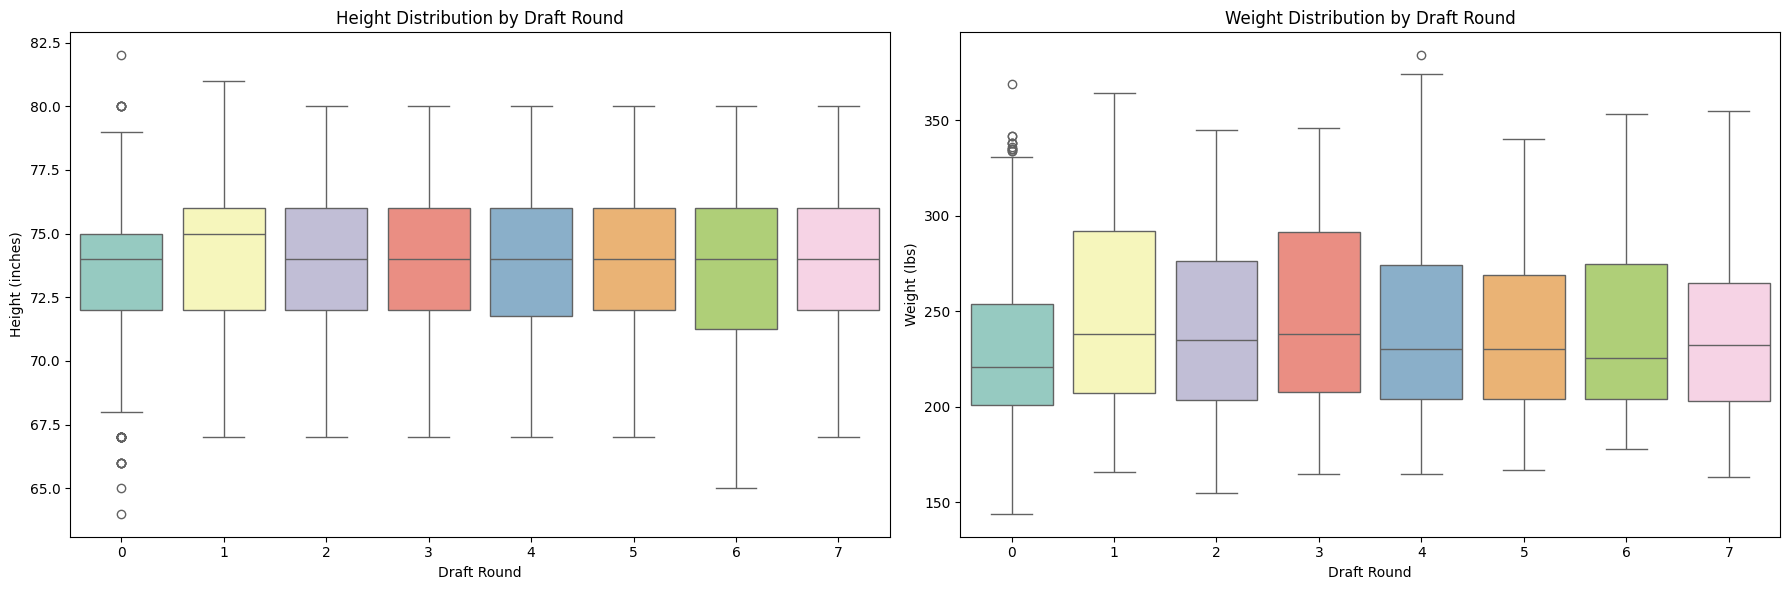

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(18, 6))


sns.boxplot(ax=axes[0], x='Round', y='Height', data=data,palette='Set3')
axes[0].set_title('Height Distribution by Draft Round')
axes[0].set_xlabel('Draft Round')
axes[0].set_ylabel('Height (inches)')


sns.boxplot(ax=axes[1], x='Round', y='Weight', data=data,palette='Set3')
axes[1].set_title('Weight Distribution by Draft Round')
axes[1].set_xlabel('Draft Round')
axes[1].set_ylabel('Weight (lbs)')

plt.tight_layout()
plt.show()


**Visualization 2: Historical Trends in Player Physical Metrics**

***Line graphs depicting the evolution of average player heights and weights over the years.***

**• Visual 2:** Line graphs showing the evolution of average player heights and weights over the years.

**• Hypothesis:** Over the years, there has been an increase in the average size and weight of drafted players.

**• Observation:** The line graph shows NFL player weight goes up and down over time. This data doesn't support the idea that players just keep getting bigger. But there was a peak in 2016 and a trend for 3 years (2013-16) where overall weight was increasing.

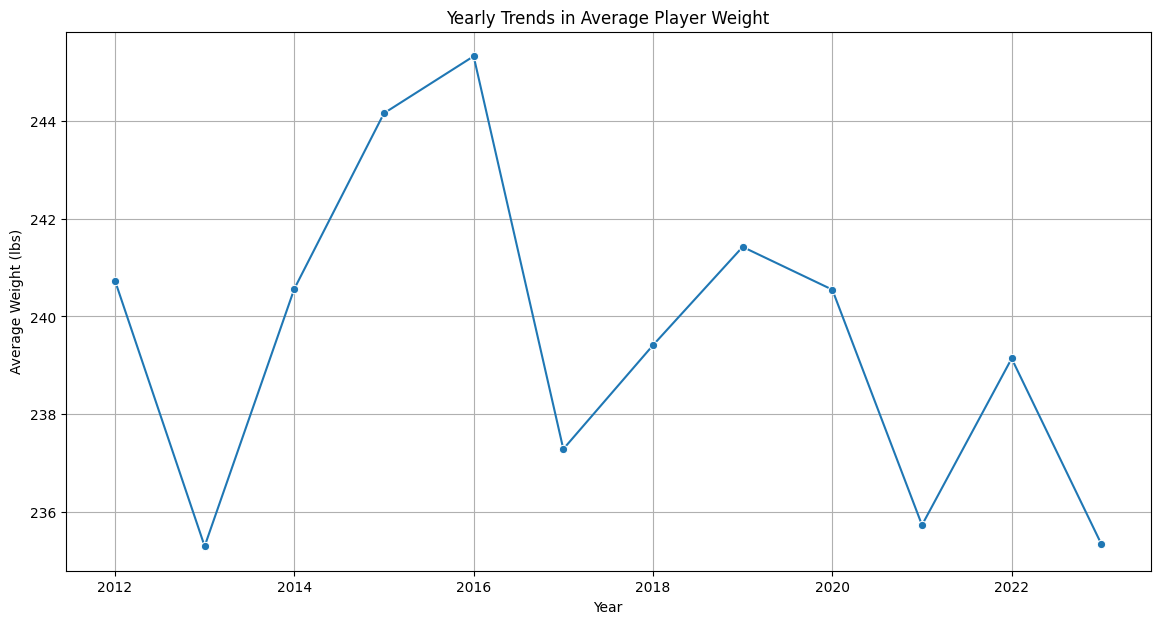

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


average_weight_per_year = data.groupby('Year')['Weight'].mean().reset_index()


plt.figure(figsize=(14, 7))
sns.lineplot(x='Year', y='Weight', data=average_weight_per_year, marker='o')
plt.title('Yearly Trends in Average Player Weight')
plt.xlabel('Year')
plt.ylabel('Average Weight (lbs)')
plt.grid(True)
plt.show()


# **Visualizations**

**- Nishant**

**Visualisation 3: College Performance and Its Correlation with Draft Success**

***Scatter plots comparing college performance metrics (e.g., rushing yards, receiving touchdowns) with draft rounds***

**• Visual 3:** Scatter plots comparing college performance metrics (e.g., rushing yards, receiving touchdowns) with draft rounds.

**• Hypothesis:** Outstanding college performance is positively correlated with being drafted in higher rounds.

**• Observation:** Early results suggest strong college performance in rushing yards and touchdowns might be linked to higher draft picks, highlighting the importance of college
achievements. However, the data also shows players with good stats are spread across all draft rounds, suggesting that other factors might also impact during the draft.



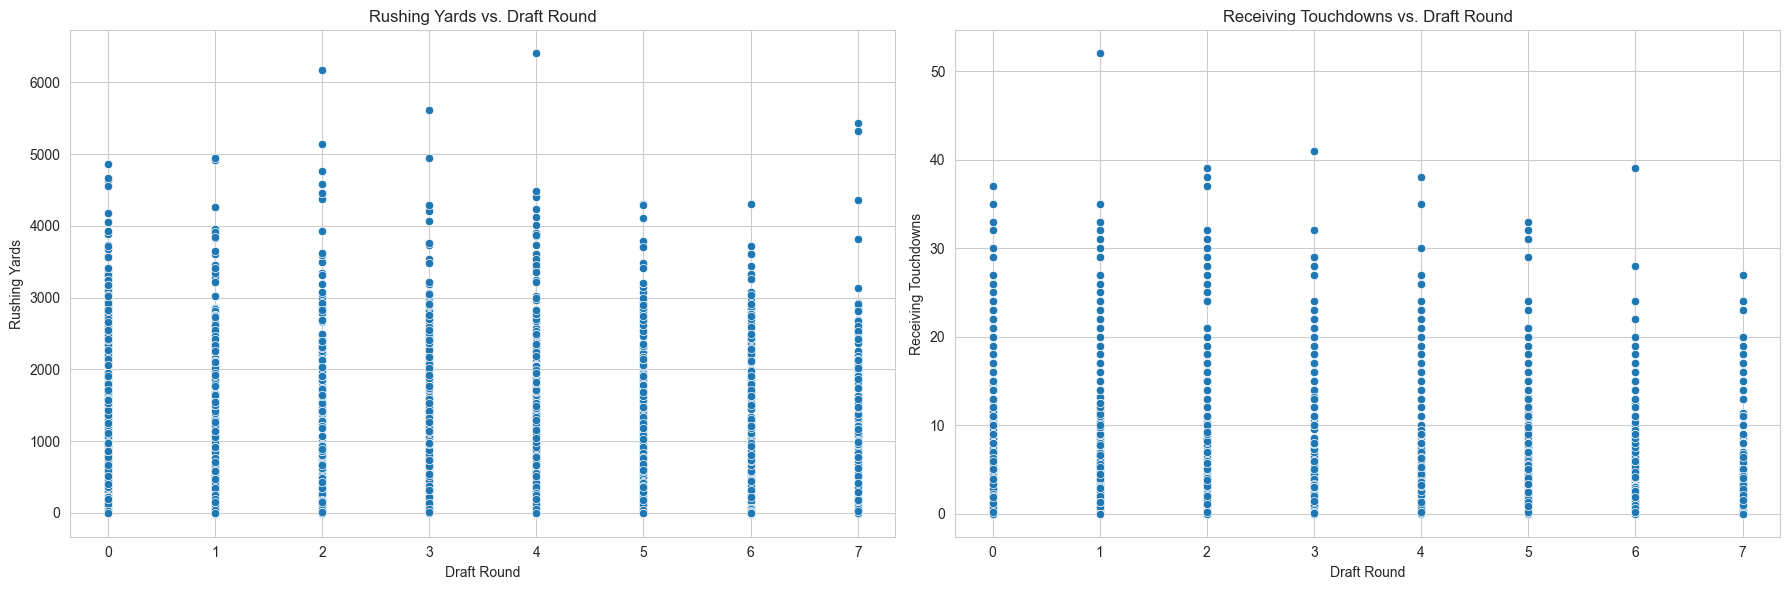

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")


fig, axes = plt.subplots(1, 2, figsize=(18, 6))


sns.scatterplot(ax=axes[0], x='Round', y='rush_yds', data=data)
axes[0].set_title('Rushing Yards vs. Draft Round')
axes[0].set_xlabel('Draft Round')
axes[0].set_ylabel('Rushing Yards')


sns.scatterplot(ax=axes[1], x='Round', y='rec_td', data=data)
axes[1].set_title('Receiving Touchdowns vs. Draft Round')
axes[1].set_xlabel('Draft Round')
axes[1].set_ylabel('Receiving Touchdowns')

plt.tight_layout()
plt.show()


***Visualization 4: Impact of Combine Performance on Draft Outcomes***

**• Visual 4:** Correlation heatmaps between combine performance metrics and draft rounds.

**• Hypothesis:** Good performance in combine drills correlates with higher draft selections.

**• Observation:** NFL combine results (speed, jumps) do show some link to earlier draft picks, suggesting the combine is still important. But the connection isn't strong, so teams likely consider other factors like game film and interviews too.

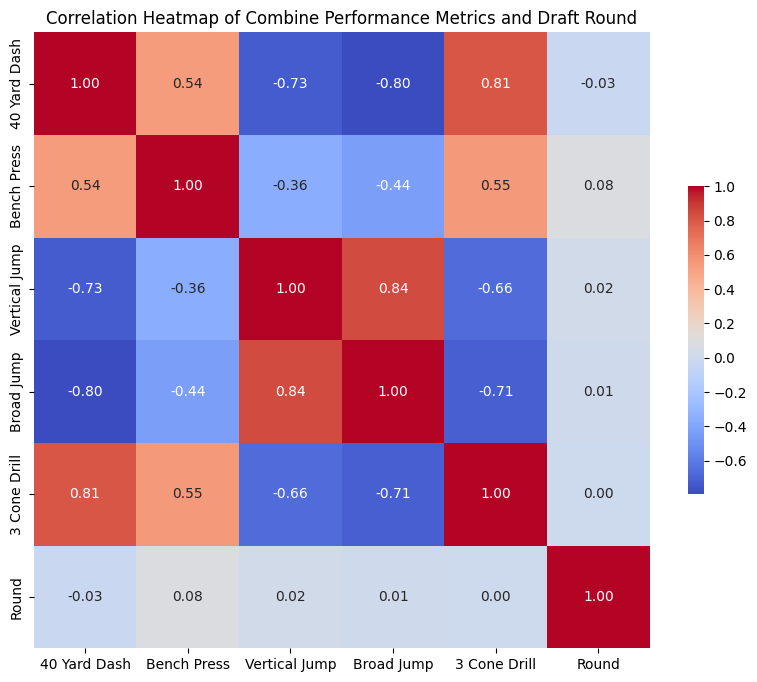

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

combine_metrics = ['40 Yard Dash', 'Bench Press', 'Vertical Jump', 'Broad Jump', '3 Cone Drill']  # example metric columns

combine_metrics.append('Round')

# Calculating the correlation matrix
corr = data[combine_metrics].corr()

# Setting up the matplotlib figure
plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'shrink': .5}, square=True)
plt.title('Correlation Heatmap of Combine Performance Metrics and Draft Round')
plt.show()

***Visualization 5: Positional Value in Draft Rounds***

**• Visual 5:** Stacked bar charts showing the distribution of drafted positions in each round.

**• Hypothesis:** Some positions (e.g., Quarterbacks, Offensive Tackles) are more likely to be drafted in earlier rounds due to their importance in the game.

**• Observation:** Most players go undrafted (Round 0). Some positions, like tackle and receiver, are usually drafted early because teams think they're valuable. Kickers and punters are drafted less often, and other positions can be drafted any round. This suggests teams consider more than just position when drafting.


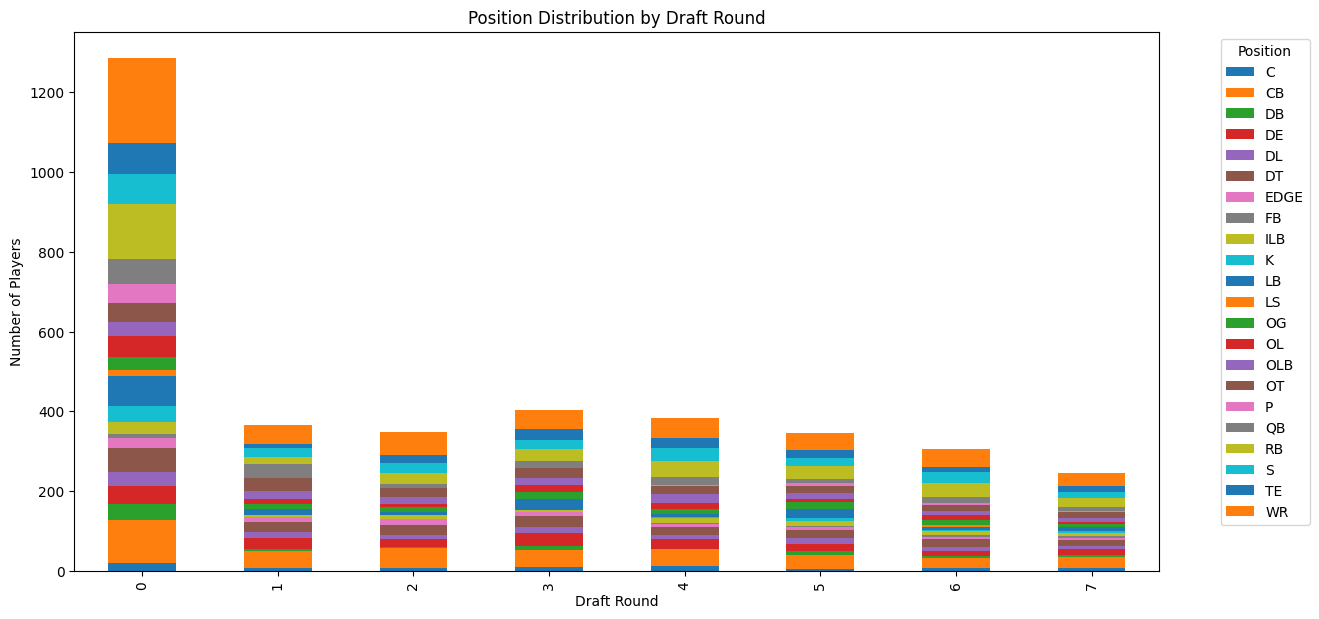

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

position_round_counts = data.groupby(['Round', 'Position']).size().unstack().fillna(0)

position_round_counts.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Position Distribution by Draft Round')
plt.xlabel('Draft Round')
plt.ylabel('Number of Players')
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

***Visualization 6: Proportion of Players Drafted by Round for Selected Positions (OT vs. Kickers/Punters)***

**• Visual 6:** The bar chart shows the count of players drafted by round for three distinct positions: Offensive Tackles (OT), Punters (P), and Kickers (K), along with those who were undrafted. We chose to explore these 3 positions more since we had some insights on these from in the EDA in Visual 5.

**• Hypothesis:** Players in key offensive and defensive positions, like Offensive Tackles, are likely to be drafted in earlier rounds, while specialized positions such as Kickers and Punters are often selected in later rounds.

**• Observation:** Offensive Tackles (OT) are heavily represented in the early rounds, with a significant number of players selected in the first round.
Punters (P) and Kickers (K) show a contrasting distribution, with a substantial proportion undrafted, and the majority of those drafted are selected in the later rounds.
The hypothesis is supported by the data, with OTs indeed being drafted earlier and more frequently, while Kickers and Punters are less prioritized in the draft process and are more likely to be undrafted.


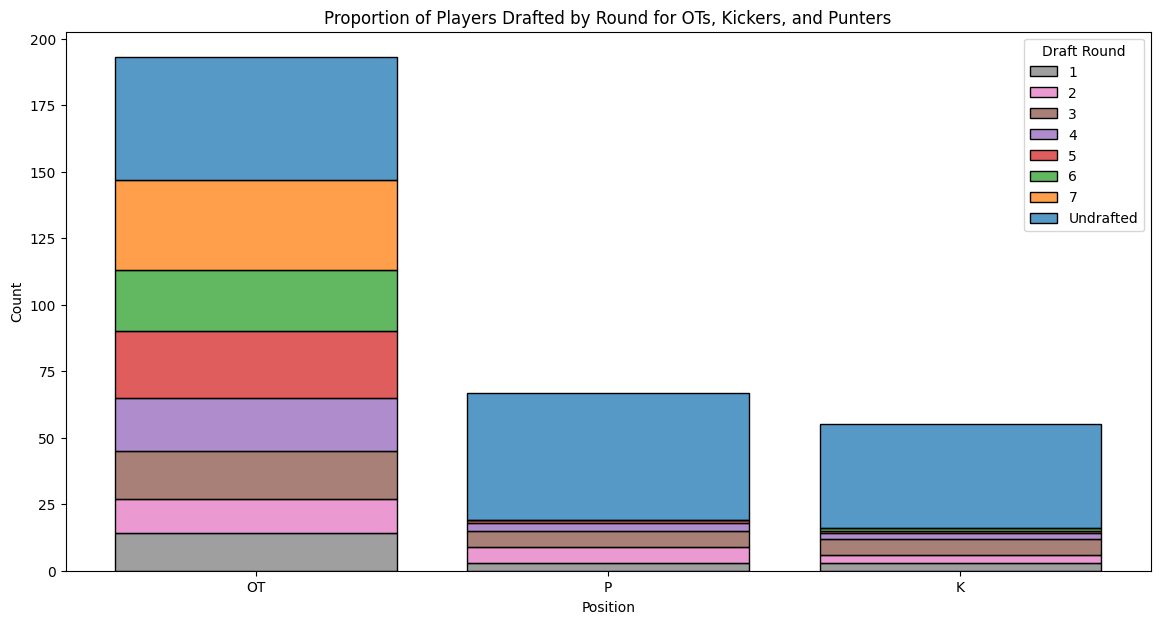

In [ ]:
data['Drafted'] = data['Round'].apply(lambda x: 'Undrafted' if x == 0 else 'Drafted')


positions_to_compare = ['OT', 'K', 'P']
draft_rounds_data = data[data['Position'].isin(positions_to_compare) & (data['Round'] <= 7)]

plt.figure(figsize=(14, 7))
sns.histplot(data=draft_rounds_data, x='Position', hue='Round', multiple='stack', palette='tab10', shrink=0.8)
plt.title('Proportion of Players Drafted by Round for OTs, Kickers, and Punters')
plt.xlabel('Position')
plt.ylabel('Count')
plt.legend(title='Draft Round', loc='upper right', labels=['1', '2', '3', '4', '5', '6', '7', 'Undrafted'])
plt.show()



```
# This is formatted as code
```

## **Rank prediction using Random Forest Classifier**

-- Vishwa Sheth

<b><u>Key components of the model</u></b>

Data Preprocessing: After imputing missing values using KNN, we convert categorical data to numeric using the get_dummies function in pandas. This conversion helps to format the data in a way that is suitable for the model.

Feature selection: We remove irrelevant features such as "Name" and "College" from consideration for prediction. Additionally, "Round" and "Pick" are excluded as they are part of the target feature.

Target feature: Currently, we aim to predict ranking using the "Round" feature. In the future, we plan to incorporate "Pick" before final submission.

Dataset split: Given that this is a ranking problem, the training dataset includes all years except for 2023. Data from 2023 will be used solely for predicting the rank.

The hyperparameters are tuned using cross-validation. The disparity between baseline measurements and best-fit measurements demonstrates an improvement in accuracy and other metrics following 5-Fold cross-validation.

Comparative Analysis of Baseline and Best-Fit Random Forest Models for Ranking Prediction

<u>Note</u>: This work is in progress; we aim to improve measurement parameters, include ranking parameters in Cross Validation instead of accuracy and include "Pick" in the target feature.

In [3]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("data/imputed_data.csv")
print(df.columns)

Index(['Name', 'Position', 'College', 'Round', 'Pick', 'Stat URL', 'Height',
       'Weight', '40 Yard Dash', 'Bench Press', 'Vertical Jump', 'Broad Jump',
       '3 Cone Drill', 'Shuttle', 'conf_abbr', 'games', 'seasons',
       'tackles_solo', 'tackles_assists', 'tackles_total', 'tackles_loss',
       'sacks', 'def_int', 'def_int_yds', 'def_int_td', 'pass_defended',
       'fumbles_rec', 'fumbles_rec_yds', 'fumbles_rec_td', 'fumbles_forced',
       'rec', 'rec_yds', 'rec_yds_per_rec', 'rec_td', 'rush_att', 'rush_yds',
       'rush_yds_per_att', 'rush_td', 'scrim_att', 'scrim_yds',
       'scrim_yds_per_att', 'scrim_td', 'Year'],
      dtype='object')


In [ ]:
df.head

<bound method NDFrame.head of                  Name Position          College  Round  Pick  \
0       Emmanuel Acho      OLB            Texas      6   204   
1           Joe Adams       WR         Arkansas      4   104   
2        Chas Alecxih       DT       Pittsburgh      0     0   
3     Frank Alexander       DE         Oklahoma      4   103   
4       Antonio Allen        S   South Carolina      7   242   
...               ...      ...              ...    ...   ...   
3679      Luke Wypler        C         Ohio St.      6   190   
3680      Bryce Young       QB          Alabama      1     1   
3681      Byron Young       DT          Alabama      3    70   
3682      Byron Young     EDGE        Tennessee      3    77   
3683    Cameron Young       DT  Mississippi St.      4   123   

                                               Stat URL  Height  Weight  \
0     https://www.sports-reference.com/cfb/players/e...    74.0   238.0   
1     https://www.sports-reference.com/cfb/players/

In [ ]:
# Classifing it in binary to train model and then predict probabilities for ranking
df.loc[df.Round != 1, "Round"] = 0

# Dropping the columns which donot contribute in prediction
all_X = df.drop(["Name", "Round", "Pick", "College"], axis=1)
all_X = pd.get_dummies(all_X)

# Splitting testing and training sets
train_X = all_X[(all_X.Year != 2023)].drop(["Year"], axis=1)
test_X = all_X[all_X.Year == 2023].drop(["Year"], axis=1)
train_y = df[(df.Year != 2023)].Round
test_y = df[df.Year == 2023].Round



In [ ]:
train_X.head()

,Height,Weight,40 Yard Dash,Bench Press,Vertical Jump,Broad Jump,3 Cone Drill,Shuttle,games,seasons,...,conf_abbr_CUSA,conf_abbr_Ind,conf_abbr_MAC,conf_abbr_MVC,conf_abbr_MWC,conf_abbr_Pac-10,conf_abbr_Pac-12,conf_abbr_SEC,conf_abbr_Sun Belt,conf_abbr_WAC
0,74.0,238.0,4.64,24.00,35.50,118.00,7.13,4.28,37.0,3.0,...,False,False,False,False,False,False,False,False,False,False
1,71.0,179.0,4.51,14.59,36.00,123.00,7.09,4.12,40.0,4.0,...,False,False,False,False,False,False,False,False,False,False
2,76.0,296.0,5.31,19.00,25.50,99.00,7.74,4.62,34.0,3.0,...,False,False,False,False,False,False,False,False,False,False
3,76.0,270.0,4.80,24.48,31.13,115.26,7.19,4.48,37.0,4.0,...,False,False,False,False,False,False,False,False,False,False
4,73.0,210.0,4.58,17.00,34.00,118.00,7.02,4.25,42.0,4.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
test_X.head()

,Height,Weight,40 Yard Dash,Bench Press,Vertical Jump,Broad Jump,3 Cone Drill,Shuttle,games,seasons,...,conf_abbr_CUSA,conf_abbr_Ind,conf_abbr_MAC,conf_abbr_MVC,conf_abbr_MWC,conf_abbr_Pac-10,conf_abbr_Pac-12,conf_abbr_SEC,conf_abbr_Sun Belt,conf_abbr_WAC
3400,70.0,216.0,4.51,19.42,33.64,115.58,7.03,4.28,31.0,3.0,...,False,False,False,False,False,False,False,False,False,False
3401,73.0,237.0,4.47,17.09,36.50,129.00,7.22,4.25,53.0,5.0,...,False,False,False,False,False,False,False,False,False,False
3402,69.0,188.0,4.32,14.92,33.00,119.26,7.02,4.19,30.0,3.0,...,False,False,False,False,False,False,False,True,False,False
3403,71.0,173.0,4.49,15.14,34.00,122.00,7.00,4.16,35.0,3.0,...,False,False,False,False,False,False,False,False,False,False
3404,74.0,282.0,4.49,27.00,37.50,125.00,7.22,4.47,36.0,4.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Define the parameter values as baseline
n_estimators = 1
max_depth = None
min_samples_split = 1000
min_samples_leaf = 1000
max_features = None
bootstrap = False


# Initialize the Random Forest classifier with custom parameters
baseline_rf = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    max_features=max_features,
                                    bootstrap=bootstrap)

# Initialize and train Random Forest classifier as baseline
# baseline_rf = RandomForestClassifier()
baseline_rf.fit(train_X, train_y)


RandomForestClassifier(bootstrap=False, max_features=None,
                       min_samples_leaf=1000, min_samples_split=1000,
                       n_estimators=1)

In [ ]:
# Make predictions on test data
baseline_preds = preds = baseline_rf.predict_proba(test_X)
count = 1

# Ranking done according to the probability scores
for i in pd.DataFrame(baseline_preds).sort_values(by=1, ascending=False).index:
    print(str(count) + " " + str(df[df.Year==2023].reset_index().at[i, "Name"]))
    count += 1

1 Israel Abanikanda
2 Mike Morris
3 Tashawn Manning
4 Michael Mayer
5 Warren McClendon
6 Jordan McFadden
7 Tanner McKee
8 Kendre Miller
9 Marvin Mims
10 Keaton Mitchell
11 Wanya Morris
12 Calijah Kancey
13 Myles Murphy
14 Lukas Van Ness
15 John Ojukwu
16 BJ Ojulari
17 Jarrett Patterson
18 Kyle Patterson
19 Jack Podlesny
20 Asim Richards
21 Jaxson Kirkland
22 Darrell Luter Jr.
23 Anton Harrison
24 Clark Phillips III
25 Malik Heath
26 Nick Herbig
27 Ronnie Hickman
28 Brandon Hill
29 Xavier Hutchinson
30 Jalin Hyatt
31 Andre Carter II
32 Rashad Torrence II
33 Thomas Incoom
34 Paris Johnson Jr.
35 Rakim Jarrett
36 Antonio Johnson
37 Quentin Johnston
38 Broderick Jones
39 Dawand Jones
40 Jaylon Jones
41 Will Anderson Jr.
42 Emil Ekiyor Jr.
43 Anthony Richardson
44 Eli Ricks
45 Kelee Ringo
46 Parker Washington
47 DJ Turner
48 Carrington Valentine
49 Deuce Vaughn
50 Andrew Vorhees
51 Dalton Wagner
52 Alex Ward
53 Carter Warren
54 Darnell Washington
55 Tyrus Wheat
56 Tavius Robinson
57 Blake W

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

# Convert predicted probabilities to binary predictions based on a threshold (e.g., 0.5)
predicted_labels = (baseline_preds[:, 1] > 0.5).astype(int)

# Evaluation for ranking metrics
# Sort the predictions based on probability scores
sorted_indices = np.argsort(-preds[:, 1])
k = 10
num_relevant = sum(test_y)

def calculate_MRR(sorted_indices, test_y):
    # Calculate Mean Reciprocal Rank (MRR)
    mrr = 0
    for idx, i in enumerate(sorted_indices):
        if test_y.iloc[i] == 1:  # Use iloc to access test_y by index
            mrr = 1 / (idx + 1)
            break
    return mrr

def calculate_MAP(sorted_indices, test_y):
    # Calculate Mean Average Precision (MAP)
    ap = 0
    for idx, i in enumerate(sorted_indices):
        if test_y.iloc[i] == 1:
            ap += sum(test_y.iloc[:idx + 1]) / (idx + 1)
    map_score = ap / num_relevant
    return map_score

def calculate_NDCG(sorted_indices, test_y):
    # Calculate Normalized Discounted Cumulative Gain (NDCG) at k=10
    dcg = 0
    idcg = sum(1 / np.log2(np.arange(2, k + 2)))
    for idx, i in enumerate(sorted_indices[:k]):
        if test_y.iloc[i] == 1:
            dcg += 1 / np.log2(idx + 2)
    ndcg = dcg / idcg
    return ndcg

def calculate_PAK(sorted_indices, test_y):
    # Calculate Precision at k (P@k)
    tp_at_k = sum(test_y.iloc[sorted_indices[:k]])
    precision_at_k = tp_at_k / k
    return precision_at_k

def calculate_RAK(sorted_indices, test_y):
    # Calculate Recall at k (R@k)
    tp_at_k = sum(test_y.iloc[sorted_indices[:k]])
    recall_at_k = tp_at_k / num_relevant
    return recall_at_k

In [ ]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from tabulate import tabulate

# Calculate all measurements
baseline_measurements = [
    ("Accuracy", accuracy_score(test_y, predicted_labels)),
    ("ROC AUC Score", roc_auc_score(test_y, baseline_preds[:, 1])),
    ("Mean Reciprocal Rank (MRR)", calculate_MRR(sorted_indices, test_y)),
    ("Mean Average Precision (MAP)", calculate_MAP(sorted_indices, test_y)),
    ("Normalized Discounted Cumulative Gain (NDCG) at k=10", calculate_NDCG(sorted_indices, test_y)),
    ("Precision at k (P@k) at k=10", calculate_PAK(sorted_indices, test_y)),
    ("Recall at k (R@k) at k=10", calculate_RAK(sorted_indices, test_y))
]

# Print measurements in a table format
print("Baseline measurements")
print(tabulate(baseline_measurements, headers=["Metric", "Value"]))


Baseline measurements
Metric                                                    Value
----------------------------------------------------  ---------
Accuracy                                              0.897887
ROC AUC Score                                         0.696552
Mean Reciprocal Rank (MRR)                            0.125
Mean Average Precision (MAP)                          0.115021
Normalized Discounted Cumulative Gain (NDCG) at k=10  0.0694312
Precision at k (P@k) at k=10                          0.1
Recall at k (R@k) at k=10                             0.0344828


In [ ]:
from sklearn.model_selection import GridSearchCV
# Training the model using Random Forest by using best parameters

param_grid = {
    'n_estimators': [100, 500, 1000]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Hypertuning parameters using 5-Fold Cross Validation method
clf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
clf.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [100, 500, 1000]}, scoring='accuracy')

In [ ]:
# Get the best parameters
best_params = clf.best_params_
print("Best Parameters:", best_params)

# Use the best estimator to make predictions
best_rf = clf.best_estimator_

Best Parameters: {'n_estimators': 100}


In [ ]:
# Predicting the probabilities of Test set
preds = best_rf.predict_proba(test_X)
count = 1

# Ranking done according to the probability scores
for i in pd.DataFrame(preds).sort_values(by=1, ascending=False).index:
    print(str(count) + " " + str(df[df.Year==2023].reset_index().at[i, "Name"]))
    count += 1

1 Bryce Young
2 C.J. Stroud
3 Jakorian Bennett
4 Dante Stills
5 Will Anderson Jr.
6 Emmanuel Forbes
7 Marvin Mims
8 Christian Gonzalez
9 Julius Brents
10 Tyler Steen
11 Darnell Wright
12 DJ Turner
13 Anthony Richardson
14 Deonte Banks
15 Nolan Smith
16 Blake Freeland
17 Lukas Van Ness
18 Jaren Hall
19 Tre'Vius Hodges-Tomlinson
20 Thomas Incoom
21 Owen Pappoe
22 Byron Young
23 Darnell Washington
24 Joe Tippmann
25 Kelee Ringo
26 Myles Brooks
27 Isaiah Foskey
28 Trenton Simpson
29 Charlie Thomas
30 Adetomiwa Adebawore
31 Dawand Jones
32 Riley Moss
33 Richard Gouraige
34 Ryan Hayes
35 Hendon Hooker
36 Carrington Valentine
37 Darius Rush
38 Tavius Robinson
39 Michael Mayer
40 Kayshon Boutte
41 Jason Taylor II
42 Zacch Pickens
43 Anthony Bradford
44 Yasir Abdullah
45 Rashee Rice
46 Jalin Hyatt
47 Rejzohn Wright
48 Nick Hampton
49 Joey Porter Jr.
50 Matt Landers
51 Quentin Johnston
52 Tanner McKee
53 Parker Washington
54 Anton Harrison
55 Andre Carter II
56 Josh Downs
57 Nick Herbig
58 Anfer

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

# Convert predicted probabilities to binary predictions based on a threshold (e.g., 0.5)
predicted_labels = (preds[:, 1] > 0.5).astype(int)

# Evaluation for ranking metrics
# Sort the predictions based on probability scores
sorted_indices = np.argsort(-preds[:, 1])

# Calculate all measurements
best_rf_measurements = [
    ("Accuracy", accuracy_score(test_y, predicted_labels)),
    ("ROC AUC Score", roc_auc_score(test_y, baseline_preds[:, 1])),
    ("Mean Reciprocal Rank (MRR)", calculate_MRR(sorted_indices, test_y)),
    ("Mean Average Precision (MAP)", calculate_MAP(sorted_indices, test_y)),
    ("Normalized Discounted Cumulative Gain (NDCG) at k=10", calculate_NDCG(sorted_indices, test_y)),
    ("Precision at k (P@k) at k=10", calculate_PAK(sorted_indices, test_y)),
    ("Recall at k (R@k) at k=10", calculate_RAK(sorted_indices, test_y))
]

# Print measurements in a table format
print("Best Fit Random Forest measurements")
print(tabulate(best_rf_measurements, headers=["Metric", "Value"]))

Best Fit Random Forest measurements
Metric                                                   Value
----------------------------------------------------  --------
Accuracy                                              0.897887
ROC AUC Score                                         0.696552
Mean Reciprocal Rank (MRR)                            1
Mean Average Precision (MAP)                          0.111314
Normalized Discounted Cumulative Gain (NDCG) at k=10  0.591927
Precision at k (P@k) at k=10                          0.5
Recall at k (R@k) at k=10                             0.172414


# Comparative Analysis of Baseline and Best-Fit Random Forest Models for Ranking Prediction

The comparison between the baseline and best-fit Random Forest models reveals notable differences in performance across various metrics. In terms of accuracy and ROC AUC score, both models exhibit similar results. However, significant improvements are observed in the best-fit model for ranking-related metrics. The Mean Reciprocal Rank (MRR) shows a substantial increase, indicating that the best-fit model provides more relevant and accurate predictions at the top of the ranked list compared to the baseline. Similarly, the Mean Average Precision (MAP) and Precision at k (P@k) at k=10 metrics demonstrate considerable enhancements, implying better precision in predicting relevant instances within the top results. Moreover, the Normalized Discounted Cumulative Gain (NDCG) at k=10 reflects a notable improvement, suggesting that the best-fit model produces more relevant results at the top ranks, which is crucial for ranking tasks. Despite these improvements, the recall at k (R@k) at k=10 remains relatively low for both models, indicating a challenge in capturing all relevant instances within the top k results.

Overall, while the baseline model provides reasonable predictive performance, the best-fit Random Forest model significantly enhances the model's ability to accurately rank and prioritize instances, particularly at the top of the list, thereby improving its utility in predicting NFL Draft.


# **Rank prediction using XGBoost Classifier**

-- Bhavya Batta

**Key components of the model**

**Data Preprocessing**: Missing values are filled in using K-nearest neighbors, and categorical data is transformed into numeric form through pandas' get_dummies method. This transformation ensures the data is properly formatted for model input.

**Feature selection**:  Features deemed irrelevant, including "Name" and "College," are omitted from the prediction process. Furthermore, "Round" and "Pick" are not considered as they contribute to the target feature.

**Target feature:** Our current goal is to predict rankings based on the "Round" feature. We intend to include "Pick" as part of the target variable in the upcoming final version.

**Dataset split:** Given that this is a ranking problem, the training dataset includes all years except for 2023. Data from 2023 will be used solely for predicting the rank.

The **hyperparameters** are tuned using cross-validation. The disparity between baseline measurements and best-fit measurements demonstrates an improvement in accuracy and other metrics following 5-Fold cross-validation.

Note: This project is ongoing, with objectives to enhance measurement criteria, replace accuracy with ranking metrics in Cross-Validation, and incorporate "Pick" into the target feature for improvement.

In [16]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np

In [4]:
# Read the CSV file
df = pd.read_csv("data/imputed_data.csv")
print(df.columns)

Index(['Name', 'Position', 'College', 'Round', 'Pick', 'Stat URL', 'Height',
       'Weight', '40 Yard Dash', 'Bench Press', 'Vertical Jump', 'Broad Jump',
       '3 Cone Drill', 'Shuttle', 'conf_abbr', 'games', 'seasons',
       'tackles_solo', 'tackles_assists', 'tackles_total', 'tackles_loss',
       'sacks', 'def_int', 'def_int_yds', 'def_int_td', 'pass_defended',
       'fumbles_rec', 'fumbles_rec_yds', 'fumbles_rec_td', 'fumbles_forced',
       'rec', 'rec_yds', 'rec_yds_per_rec', 'rec_td', 'rush_att', 'rush_yds',
       'rush_yds_per_att', 'rush_td', 'scrim_att', 'scrim_yds',
       'scrim_yds_per_att', 'scrim_td', 'Year'],
      dtype='object')


In [5]:
df.head()

,Name,Position,College,Round,Pick,Stat URL,Height,Weight,40 Yard Dash,Bench Press,...,rec_td,rush_att,rush_yds,rush_yds_per_att,rush_td,scrim_att,scrim_yds,scrim_yds_per_att,scrim_td,Year
0,Emmanuel Acho,OLB,Texas,6,204,https://www.sports-reference.com/cfb/players/e...,74.0,238.0,4.64,24.00,...,5.29,199.20,1282.58,8.83,14.91,239.71,1747.91,8.22,20.20,2012
1,Joe Adams,WR,Arkansas,4,104,https://www.sports-reference.com/cfb/players/j...,71.0,179.0,4.51,14.59,...,8.50,4.00,69.50,11.65,0.00,96.00,1393.50,14.45,8.50,2012
2,Chas Alecxih,DT,Pittsburgh,0,0,https://www.sports-reference.com/cfb/players/c...,76.0,296.0,5.31,19.00,...,0.00,1.19,5.20,-0.68,0.36,1.36,5.55,0.86,0.36,2012
3,Frank Alexander,DE,Oklahoma,4,103,https://www.sports-reference.com/cfb/players/f...,76.0,270.0,4.80,24.48,...,2.17,22.98,75.37,4.12,4.24,36.81,231.59,6.49,6.41,2012
4,Antonio Allen,S,South Carolina,7,242,https://www.sports-reference.com/cfb/players/a...,73.0,210.0,4.58,17.00,...,1.68,374.69,2061.25,4.94,19.21,420.39,2397.36,6.43,20.89,2012


In [6]:
df.loc[df.Round != 1, "Round"] = 0

# Dropping the columns which donot contribute in prediction
all_X = df.drop(["Name", "Round", "Pick", "College"], axis=1)
all_X = pd.get_dummies(all_X)

# Splitting testing and training sets
train_X = all_X[(all_X.Year != 2023)].drop(["Year"], axis=1)
test_X = all_X[all_X.Year == 2023].drop(["Year"], axis=1)
train_y = df[(df.Year != 2023)].Round
test_y = df[df.Year == 2023].Round

In [7]:
train_X.head()

,Height,Weight,40 Yard Dash,Bench Press,Vertical Jump,Broad Jump,3 Cone Drill,Shuttle,games,seasons,...,conf_abbr_CUSA,conf_abbr_Ind,conf_abbr_MAC,conf_abbr_MVC,conf_abbr_MWC,conf_abbr_Pac-10,conf_abbr_Pac-12,conf_abbr_SEC,conf_abbr_Sun Belt,conf_abbr_WAC
0,74.0,238.0,4.64,24.00,35.50,118.00,7.13,4.28,37.0,3.0,...,False,False,False,False,False,False,False,False,False,False
1,71.0,179.0,4.51,14.59,36.00,123.00,7.09,4.12,40.0,4.0,...,False,False,False,False,False,False,False,False,False,False
2,76.0,296.0,5.31,19.00,25.50,99.00,7.74,4.62,34.0,3.0,...,False,False,False,False,False,False,False,False,False,False
3,76.0,270.0,4.80,24.48,31.13,115.26,7.19,4.48,37.0,4.0,...,False,False,False,False,False,False,False,False,False,False
4,73.0,210.0,4.58,17.00,34.00,118.00,7.02,4.25,42.0,4.0,...,False,False,False,False,False,False,False,False,False,False


In [8]:
test_X.head()

,Height,Weight,40 Yard Dash,Bench Press,Vertical Jump,Broad Jump,3 Cone Drill,Shuttle,games,seasons,...,conf_abbr_CUSA,conf_abbr_Ind,conf_abbr_MAC,conf_abbr_MVC,conf_abbr_MWC,conf_abbr_Pac-10,conf_abbr_Pac-12,conf_abbr_SEC,conf_abbr_Sun Belt,conf_abbr_WAC
3400,70.0,216.0,4.51,19.42,33.64,115.58,7.03,4.28,31.0,3.0,...,False,False,False,False,False,False,False,False,False,False
3401,73.0,237.0,4.47,17.09,36.50,129.00,7.22,4.25,53.0,5.0,...,False,False,False,False,False,False,False,False,False,False
3402,69.0,188.0,4.32,14.92,33.00,119.26,7.02,4.19,30.0,3.0,...,False,False,False,False,False,False,False,True,False,False
3403,71.0,173.0,4.49,15.14,34.00,122.00,7.00,4.16,35.0,3.0,...,False,False,False,False,False,False,False,False,False,False
3404,74.0,282.0,4.49,27.00,37.50,125.00,7.22,4.47,36.0,4.0,...,False,False,False,False,False,False,False,False,False,False


In [10]:
# Initialize the baseline XGBoost classifier with custom parameters
baseline_XGB = xgb.XGBClassifier(colsample_bytree=0.7,
 eta= 0.001,
 eval_metric= 'mae',
 max_depth= 6,
 min_child_weight= 15,
 objective= 'binary:logistic',
 subsample= 0.7)

baseline_XGB.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.001, eval_metric='mae',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=15, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [13]:
# Predict on the testing data
XGBbaseline_pred = baseline_XGB.predict(test_X)

# Calculate accuracy
accuracy = accuracy_score(test_y, XGBbaseline_pred)
print("Accuracy:", accuracy)

Accuracy: 0.897887323943662


In [14]:
XGBbaseline_preds = baseline_XGB.predict_proba(test_X)
count = 1

# Ranking done according to the probability scores
for i in pd.DataFrame(XGBbaseline_preds).sort_values(by=1, ascending=False).index:
    print(str(count) + " " + str(df[df.Year==2023].reset_index().at[i, "Name"]))
    count += 1

1 Christian Gonzalez
2 Marvin Mims
3 Jakorian Bennett
4 Jalin Hyatt
5 DJ Turner
6 Anthony Richardson
7 Emmanuel Forbes
8 Byron Young
9 Keaton Mitchell
10 Kelee Ringo
11 Brandon Hill
12 Devon Achane
13 Trenton Simpson
14 Jahmyr Gibbs
15 Tyler Scott
16 Carrington Valentine
17 Dawand Jones
18 Quentin Johnston
19 Tyler Steen
20 Wanya Morris
21 Tavius Robinson
22 Eli Ricks
23 Lukas Van Ness
24 Rejzohn Wright
25 Asim Richards
26 Blake Freeland
27 Gervon Dexter
28 YaYa Diaby
29 Will Anderson Jr.
30 John Ojukwu
31 Rakim Jarrett
32 Joe Tippmann
33 Jon Gaines
34 Malaesala Aumavae-Laulu
35 Josh Downs
36 Anton Harrison
37 Nick Herbig
38 Carter Warren
39 Ali Gaye
40 Nolan Smith
41 Luke Schoonmaker
42 Isaiah Foskey
43 Yasir Abdullah
44 BJ Ojulari
45 C.J. Stroud
46 Broderick Jones
47 Matt Landers
48 Peter Skoronski
49 Bryan Bresee
50 Tanner McKee
51 Nick Hampton
52 Bijan Robinson
53 Bryce Ford-Wheaton
54 Thomas Incoom
55 Myles Murphy
56 Michael Mayer
57 Tre'Vius Hodges-Tomlinson
58 Darnell Wright
59 

In [19]:
# Convert predicted probabilities to binary predictions based on a threshold (e.g., 0.5)
XGBpredicted_labels = (XGBbaseline_preds[:, 1] > 0.5).astype(int)

# Evaluation for ranking metrics
# Sort the predictions based on probability scores
sorted_indices = np.argsort(-XGBbaseline_preds[:, 1])
k = 10
num_relevant = sum(test_y)

def calculate_MRR(sorted_indices, test_y):
    # Calculate Mean Reciprocal Rank (MRR)
    mrr = 0
    for idx, i in enumerate(sorted_indices):
        if test_y.iloc[i] == 1:  # Use iloc to access test_y by index
            mrr = 1 / (idx + 1)
            break
    return mrr

def calculate_MAP(sorted_indices, test_y):
    # Calculate Mean Average Precision (MAP)
    ap = 0
    for idx, i in enumerate(sorted_indices):
        if test_y.iloc[i] == 1:
            ap += sum(test_y.iloc[:idx + 1]) / (idx + 1)
    map_score = ap / num_relevant
    return map_score

def calculate_NDCG(sorted_indices, test_y):
    # Calculate Normalized Discounted Cumulative Gain (NDCG) at k=10
    dcg = 0
    idcg = sum(1 / np.log2(np.arange(2, k + 2)))
    for idx, i in enumerate(sorted_indices[:k]):
        if test_y.iloc[i] == 1:
            dcg += 1 / np.log2(idx + 2)
    ndcg = dcg / idcg
    return ndcg

def calculate_PAK(sorted_indices, test_y):
    # Calculate Precision at k (P@k)
    tp_at_k = sum(test_y.iloc[sorted_indices[:k]])
    precision_at_k = tp_at_k / k
    return precision_at_k

def calculate_RAK(sorted_indices, test_y):
    # Calculate Recall at k (R@k)
    tp_at_k = sum(test_y.iloc[sorted_indices[:k]])
    recall_at_k = tp_at_k / num_relevant
    return recall_at_k

In [22]:
from tabulate import tabulate
from sklearn.metrics import accuracy_score, roc_auc_score

# Calculate all measurements
baseline_measurements = [
    ("Accuracy", accuracy_score(test_y, XGBpredicted_labels)),
    ("ROC AUC Score", roc_auc_score(test_y, XGBbaseline_preds[:, 1])),
    ("Mean Reciprocal Rank (MRR)", calculate_MRR(sorted_indices, test_y)),
    ("Mean Average Precision (MAP)", calculate_MAP(sorted_indices, test_y)),
    ("Normalized Discounted Cumulative Gain (NDCG) at k=10", calculate_NDCG(sorted_indices, test_y)),
    ("Precision at k (P@k) at k=10", calculate_PAK(sorted_indices, test_y)),
    ("Recall at k (R@k) at k=10", calculate_RAK(sorted_indices, test_y))
]

# Print measurements in a table format
print("Baseline measurements")
print(tabulate(baseline_measurements, headers=["Metric", "Value"]))

Baseline measurements
Metric                                                   Value
----------------------------------------------------  --------
Accuracy                                              0.897887
ROC AUC Score                                         0.764841
Mean Reciprocal Rank (MRR)                            1
Mean Average Precision (MAP)                          0.110987
Normalized Discounted Cumulative Gain (NDCG) at k=10  0.371854
Precision at k (P@k) at k=10                          0.3
Recall at k (R@k) at k=10                             0.103448


In [23]:
best_XGB = xgb.XGBClassifier(
    colsample_bytree=0.8,
    eta=0.1,
    eval_metric='logloss',
    max_depth=6,
    min_child_weight=1,
    objective='binary:logistic',
    subsample=0.8
)

# Hypertuning parameters using 5-Fold Cross Validation method
scores = cross_val_score(best_XGB, train_X, train_y, cv=5)

best_XGB.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [24]:
# Predict on the testing data
y_pred = best_XGB.predict(test_X)

# Calculate accuracy
accuracy = accuracy_score(test_y, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8943661971830986


In [25]:
# Predicting the probabilities of Test set
preds = best_XGB.predict_proba(test_X)
count = 1

# Ranking done according to the probability scores
for i in pd.DataFrame(preds).sort_values(by=1, ascending=False).index:
    print(str(count) + " " + str(df[df.Year==2023].reset_index().at[i, "Name"]))
    count += 1

1 Dawand Jones
2 Darnell Wright
3 Byron Young
4 Marvin Mims
5 Anthony Richardson
6 Emmanuel Forbes
7 C.J. Stroud
8 Kelee Ringo
9 Anton Harrison
10 Jakorian Bennett
11 Will Anderson Jr.
12 Tyler Steen
13 Rejzohn Wright
14 Thomas Incoom
15 Richard Gouraige
16 Lukas Van Ness
17 Adetomiwa Adebawore
18 Christian Gonzalez
19 Michael Mayer
20 Anthony Bradford
21 YaYa Diaby
22 Joe Tippmann
23 Wanya Morris
24 Quentin Johnston
25 Blake Freeland
26 Bryce Young
27 Asim Richards
28 Carrington Valentine
29 Broderick Jones
30 Malaesala Aumavae-Laulu
31 Calijah Kancey
32 DJ Turner
33 Isaiah Foskey
34 Matthew Bergeron
35 Gervon Dexter
36 Mazi Smith
37 Ryan Hayes
38 Trenton Simpson
39 Carter Warren
40 Nolan Smith
41 John Ojukwu
42 Jalin Hyatt
43 Henry To'oTo'o
44 Jon Gaines
45 Zach Charbonnet
46 Zach Harrison
47 Tyree Wilson
48 Jonathan Mingo
49 Tavius Robinson
50 Luke Schoonmaker
51 Tanner McKee
52 Bijan Robinson
53 Peter Skoronski
54 Rakim Jarrett
55 Robert Beal
56 Darrell Luter Jr.
57 Paris Johnson J

In [29]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Convert predicted probabilities to binary predictions based on a threshold (e.g., 0.5)
predicted_labels = (preds[:, 1] > 0.5).astype(int)

# Evaluation for ranking metrics
# Sort the predictions based on probability scores
sorted_indices = np.argsort(-preds[:, 1])

# Calculate all measurements
best_rf_measurements = [
    ("Accuracy", accuracy_score(test_y, predicted_labels)),
    ("ROC AUC Score", roc_auc_score(test_y, preds[:, 1])),
    ("Mean Reciprocal Rank (MRR)", calculate_MRR(sorted_indices, test_y)),
    ("Mean Average Precision (MAP)", calculate_MAP(sorted_indices, test_y)),
    ("Normalized Discounted Cumulative Gain (NDCG) at k=10", calculate_NDCG(sorted_indices, test_y)),
    ("Precision at k (P@k) at k=10", calculate_PAK(sorted_indices, test_y)),
    ("Recall at k (R@k) at k=10", calculate_RAK(sorted_indices, test_y))
]

# Print measurements in a table format
print("Best Fit measurements")
print(tabulate(best_rf_measurements, headers=["Metric", "Value"]))

Best Fit measurements
Metric                                                   Value
----------------------------------------------------  --------
Accuracy                                              0.894366
ROC AUC Score                                         0.766329
Mean Reciprocal Rank (MRR)                            0.5
Mean Average Precision (MAP)                          0.114885
Normalized Discounted Cumulative Gain (NDCG) at k=10  0.442022
Precision at k (P@k) at k=10                          0.5
Recall at k (R@k) at k=10                             0.172414


# **Comparative Analysis of Baseline and Best-Fit XGBoost model for Ranking Prediction**

**Accuracy**: Baseline is slightly higher, indicating it correctly classified a marginally higher percentage of the total.
ROC AUC Score: Both results are identical, showing the same ability to discriminate between classes.

**MRR**: Baseline is perfect, indicating it always ranks the correct item highest. Baseline result shows a significant drop, which could be critical if the goal is to rank a correct item as high as possible.

**MAP:** Best fit is slightly better, indicating a slight improvement in the ranking of relevant items across queries.

**NDCG at k=10:** Best fit is higher, showing it ranks relevant items more effectively within the top 10 positions.

**P@k at k=10:** Best fit is significantly higher, suggesting it has a better top-10 precision.

**R@k at k=10:** Best fit is also higher here, indicating it retrieves a higher proportion of relevant items within its top 10 predictions.

### **Conclusion**

For Ranking Tasks: If the focus is on ranking performance, particularly in retrieving and ranking the most relevant items as high as possible, Best fit is better. It shows superior performance in MAP, NDCG, P@k, and R@k, which are critical for ranking and recommendation systems.

# **Reflection**


**What is the most challenging part of the project that you’ve encountered so far?**

Tackling the use of the "Round" feature in our NFL data to predict which players would make the cut was a significant challenge, diverging notably from traditional classification problems. The ordinal nature of draft rounds required an approach that recognized the inherent ranking, not just discrete categories. Standard classification models and accuracy metrics fell short in addressing the nuanced complexity of predicting players' success based on draft rounds, due to their inability to grasp the ordered significance of the data. By pivoting to strategies that accommodate the ordinality in predictions and employing ranking-specific evaluation metrics, we successfully navigated this challenge. This adaptation underscored the importance of innovative problem-solving and marked a significant achievement in our project, demonstrating our capacity to extend beyond conventional methodologies to yield meaningful insights in the context of sports analytics.

What are your initial insights? - data related
Are there any concrete results you can show at this point? If not, why not? - yes, the improve in ranking measurements using 2 ML models
Going forward, what are the current biggest problems you’re facing? - using pick along with round to predit ranking
Do you think you are on track with your project? If not, what parts do you need to
dedicate more time to? - yes
Given your initial exploration of the data, is it worth proceeding with your project,why? If not, how will you move forward (method, data etc)?